In [4]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt 
import scipy.integrate as spint

import scipy.optimize as spopt
import numpy as np
import tqdm.notebook
from jax import config
config.update('jax_enable_x64', True)
import time

In [5]:
sigma = 1.
const_force = jnp.array([0.1, 0.1, -0.01, 0.01])

def rhs_constant(x, t):
    return jnp.array([x[1], -x[0] * (1 + x[2]**2), x[3], -x[2] * (1 + x[0]**2)]) + const_force

rhs = rhs_constant
x0 = jnp.hstack((jnp.array([1, 0]), sigma * jax.random.normal(jax.random.PRNGKey(1), (2,))))
print(x0)

[ 1.          0.          0.17269028 -0.46084179]


In [6]:
delta_t = 1e-1
final_T = 50
num_T = 500
t_range = jnp.linspace(0, final_T, num=num_T+1)
print(t_range, t_range.shape)
traj = spint.odeint(rhs, x0, t_range)

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

In [7]:
traj

array([[ 1.        ,  0.        ,  0.17269028, -0.46084179],
       [ 1.00536344, -0.09258112,  0.12408493, -0.48966592],
       [ 1.00152258, -0.18400285,  0.07309057, -0.50850139],
       ...,
       [ 0.83834056, -0.67368059, -0.33779003, -0.1402519 ],
       [ 0.77690038, -0.75408982, -0.34990692, -0.0823216 ],
       [ 0.70775038, -0.82766952, -0.35632298, -0.02643873]])

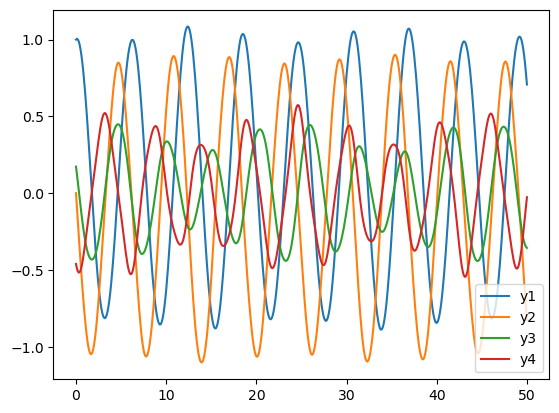

In [8]:
plt.plot(t_range, traj[:, 0], label="y1")
plt.plot(t_range, traj[:, 1], label="y2")
plt.plot(t_range, traj[:, 2], label="y3")
plt.plot(t_range, traj[:, 3], label="y4")
plt.legend()

In [9]:
control_hist_array = np.repeat(np.array(const_force).reshape(-1, 1), num_T+1, axis=1) * delta_t
control_hist_array.shape

(4, 501)

In [10]:
N = int(1e2)
st = time.time()
total_history = np.zeros((num_T + 1, 2, int(N)))
total_history_control = np.zeros((num_T + 1, 2, int(N)))
key = jax.random.PRNGKey(1)
for i in tqdm.notebook.tqdm(range(N)):
    key, subkey = jax.random.split(key, 2)
    cur_x0 = jnp.hstack((jnp.array([1, 0]), sigma * jax.random.normal(subkey, (2,))))
    current_traj = spint.odeint(rhs, cur_x0, t_range)
    total_history[:, :, i] = current_traj[:, :2]
proj_total_hist = np.mean(total_history, axis=2)
fin = time.time()
print("MC runtime =", fin - st)

  0%|          | 0/100 [00:00<?, ?it/s]

MC runtime = 13.21461009979248


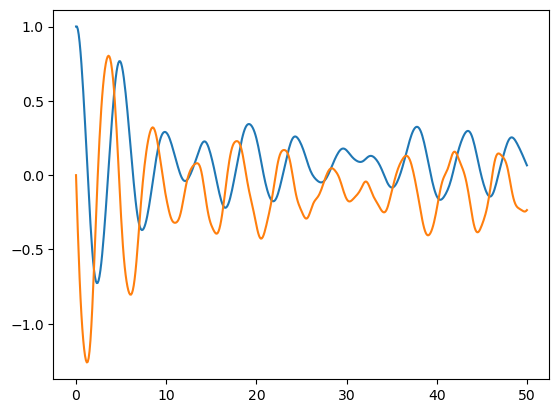

In [11]:
plt.plot(t_range, proj_total_hist[:, 0])
plt.plot(t_range, proj_total_hist[:, 1])

In [13]:
Gp = traj[1:, :2].T - control_hist_array[:2, :-1] * delta_t
Gm = traj[:-1, :2].T

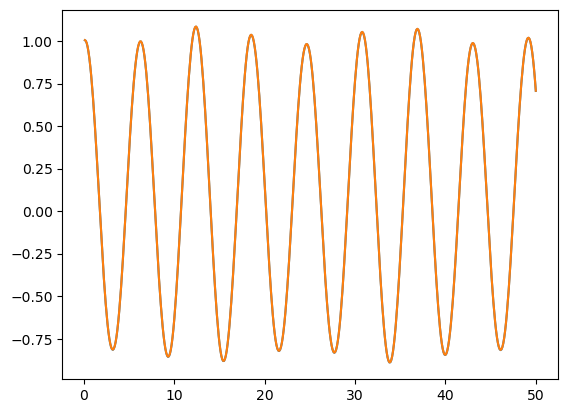

In [14]:
plt.plot(t_range[1:], Gp[0, :])
plt.plot(t_range[1:], traj[1:, 0])

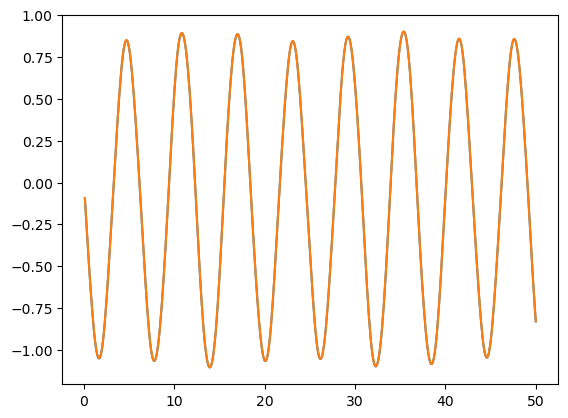

In [15]:
plt.plot(t_range[1:], Gp[1, :])
plt.plot(t_range[1:], traj[1:, 1])

In [16]:
print(Gm.shape, Gp.shape)
A_dmd = Gp @ np.linalg.pinv(Gm)

(2, 500) (2, 500)


In [17]:
A_dmd.shape

(2, 2)

In [18]:
control_hist_array.shape

(4, 501)

In [19]:
A_dmd

array([[ 0.99695766,  0.09777826],
       [-0.10285535,  0.99306018]])

In [20]:
# Extract spectrum of A_dmd and resonstruct trajectory from it
eigval_dmd, eigvec_dmd = np.linalg.eig(A_dmd)

def get_prediction_with_control(A, x0, t_range, control):
    prediction = np.zeros((x0.shape[0], len(t_range)))
    prediction[:, 0] = x0.copy()
    for i in range(1, len(t_range)):
        prediction[:, i] = A @ prediction[:, i-1] + delta_t * control_hist_array[:2, i-1]
    return prediction 
dmd_pred_traj = get_prediction_with_control(A_dmd, x0[:2], t_range, control_hist_array[:2,])

In [21]:
dmd_pred_traj.shape,t_range.shape,eigval_dmd, abs(eigval_dmd)

((2, 501),
 (501,),
 array([0.99500892+0.10026574j, 0.99500892-0.10026574j]),
 array([1.00004798, 1.00004798]))

Text(0, 0.5, '$y_1$')

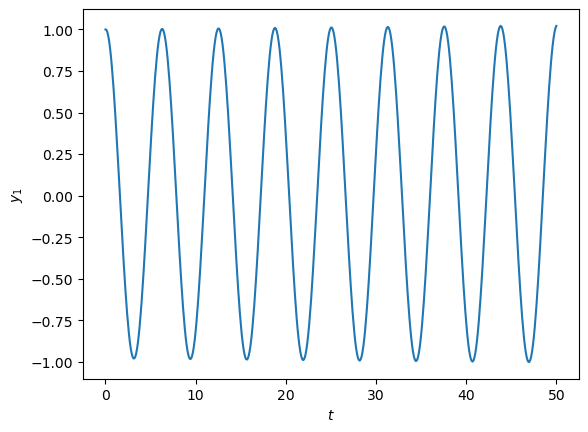

In [22]:
plt.plot(t_range, dmd_pred_traj[0, :].real)
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_2$')

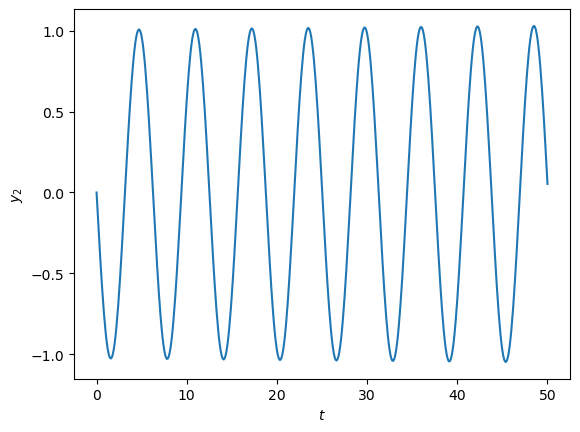

In [23]:
plt.plot(t_range, dmd_pred_traj[1, :].real)
plt.xlabel("$t$")
plt.ylabel("$y_2$")


In [24]:
# Function to generate trajectory for MZDMD approach
def generate_traj_mzdmd(A, t_range, x0, K0):
    n = x0.shape[0]
    I = jnp.eye(n)
    M = I - 2 * (A - I) @ jnp.linalg.inv(A + I)
    traj = np.zeros((x0.shape[0], t_range.shape[0]))
    traj[:, 0] = x0.copy()
    for i in range(1, t_range.shape[0]):
        x_next = A @ traj[:, i-1] + control_hist_array[:2, i-1] * delta_t
        correction = jnp.mean(jnp.linalg.inv(A - I) @ jsp.linalg.expm((i-1) * (A - I)) @ (jnp.linalg.matrix_power(M, i-1) - I) @ K0, axis=1)
        x_next -= delta_t**2 * correction 
        traj[:, i] = x_next.copy()
    return traj

In [25]:
def compute_M(A):
    n = A.shape[0]
    I = jnp.eye(n)
    M = I - 2 * (A - I) @  jnp.linalg.inv(A + I)
    return M

def body_fun(carry, x):
    K0, cur_matrix_exp, matrix_exp, cur_M_power, M, I = carry
    y = cur_matrix_exp @ (cur_M_power - I) @ K0
    y_mean = jnp.mean(y, axis=1)
    carry = (K0, cur_matrix_exp @ matrix_exp, matrix_exp, cur_M_power @ M, M, I)
    return carry, y_mean


def compute_f_scan(A, K0, num_cols, delta_t, num_rows):
    F = jnp.zeros((num_rows, num_cols))
    I = jnp.eye(num_rows)
    M = compute_M(A)
    matrix_exp = jsp.linalg.expm(A - I)
    _, Fpart = jax.lax.scan(body_fun, (K0, matrix_exp, matrix_exp, M, M, I), jnp.arange(1, num_cols))
    F = F.at[:, 1:].set(Fpart.T)
    return F

from functools import partial

@partial(jax.jit, static_argnums=(3, 4))
def compute_M_tilde(A, delta_t, K0, num_cols, num_rows):
    I = jnp.eye(num_rows)
    factor_matrix = jnp.linalg.inv(A - I)
    estimated_snapshots = compute_f_scan(A, K0, num_cols, delta_t, num_rows)
    M_tilde = factor_matrix @ estimated_snapshots
    return M_tilde 

In [26]:
@jax.jit 
def objective(A, Gp, Gm, delta_t, K0):
    # A = jnp.reshape(A_, (2, 2))
    M = compute_M_tilde(A, delta_t, K0, Gp.shape[1], Gp.shape[0])
    residual = Gp - A @ Gm + delta_t**2 * M
    return jnp.sum(residual**2)

In [34]:
import optax
learning_rate = 1e-3
adam_optimizer = optax.adam(learning_rate)
num_internal_adam_iter = 10

def proxy_obj(A_pert, K0):
    A = A_dmd + delta_t * A_pert
    return objective(A, Gp, Gm, delta_t, K0)

@jax.jit
def step_optax(params, opt_state, K0):
    loss_value, grads = jax.value_and_grad(proxy_obj)(params, K0)
    updates, opt_state = adam_optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

In [35]:
# Initialization of optimizer
opt_state = adam_optimizer.init(jnp.zeros((2,2)))
# Initialization of hidden parts of the dynamics
K0 = sigma * jax.random.normal(jax.random.PRNGKey(0), (2, 1))
K0 /= jnp.linalg.norm(K0)
print(jnp.linalg.norm(K0))

0.9999999999999999


In [36]:
params = jnp.zeros((2,2))
loss_hist = []
proxy_obj(params, K0)

Array(7.15089089, dtype=float64)

In [37]:
num_internal_adam_iter = 150
start = time.time()
for i in range(num_internal_adam_iter):
    params, opt_state, loss_value = step_optax(params, opt_state, K0)
    print("Iteration = {}, loss = {}".format(i, loss_value))
    loss_hist.append(loss_value)
A_mzdmd = A_dmd + delta_t * params.copy()
gen = np.random.default_rng(42)
rand_part = gen.standard_normal((2, 1000))
mz_dmd_traj = generate_traj_mzdmd(A_mzdmd, t_range, x0[:2], rand_part)
fin = time.time()
print("OPc runtime =", fin - start)
print(jnp.linalg.eigvals(A_mzdmd))

Iteration = 0, loss = 7.150890885736283
Iteration = 1, loss = 7.112351680578861
Iteration = 2, loss = 7.074697483682574
Iteration = 3, loss = 7.03791165002517
Iteration = 4, loss = 7.0019767171731555
Iteration = 5, loss = 6.966874519466359
Iteration = 6, loss = 6.932586298507165
Iteration = 7, loss = 6.899092809320945
Iteration = 8, loss = 6.86637442165922
Iteration = 9, loss = 6.834411216015737
Iteration = 10, loss = 6.803183074015289
Iteration = 11, loss = 6.7726697629219945
Iteration = 12, loss = 6.742851014112569
Iteration = 13, loss = 6.713706595412107
Iteration = 14, loss = 6.6852163772931155
Iteration = 15, loss = 6.657360392972144
Iteration = 16, loss = 6.6301188925262435
Iteration = 17, loss = 6.603472391167268
Iteration = 18, loss = 6.5774017118893
Iteration = 19, loss = 6.551888022713585
Iteration = 20, loss = 6.526912868801372
Iteration = 21, loss = 6.502458199707678
Iteration = 22, loss = 6.478506392097426
Iteration = 23, loss = 6.455040268211615
Iteration = 24, loss = 6.4

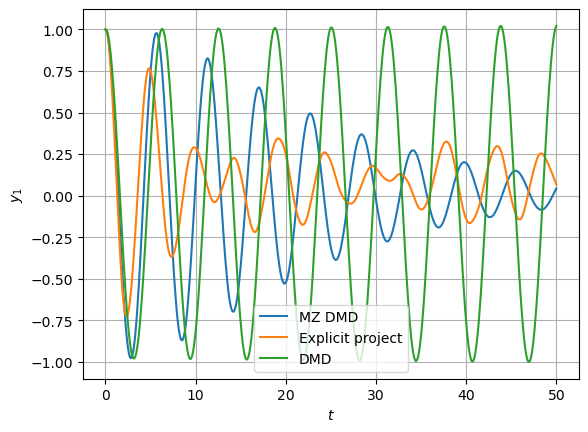

In [38]:
plt.plot(t_range, mz_dmd_traj[0], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 0], label="Explicit project")
plt.plot(t_range, dmd_pred_traj[0, :].real, label="DMD")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_1$")
plt.grid()

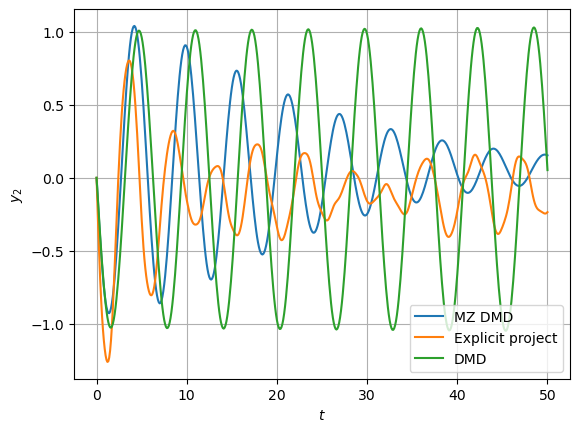

In [39]:
plt.plot(t_range, mz_dmd_traj[1], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 1], label="Explicit project")
plt.plot(t_range, dmd_pred_traj[1, :].real, label="DMD")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_2$")
plt.grid()

In [40]:
num_samples_for_std = 100
mz_dmd_traj = np.zeros((num_samples_for_std, 2, t_range.shape[0]))
for i in range(num_samples_for_std):
    rand_part = gen.standard_normal((2, 1000))
    mz_dmd_traj[i] = generate_traj_mzdmd(A_mzdmd, t_range, x0[:2], rand_part)

In [41]:
np.std(mz_dmd_traj, axis=0).mean(axis=1)

array([0.06684343, 0.06698349])